# Demo Procesamiento Lenguaje Natural (PLN) - RNA: LSTM

**CONTEXTO a tratar:**

Se tiene un *dataset* con comentarios realizados en determinadas aplicaciones de la tienda de *Android*. A cada comentario se le asocia una cantidad de estrellas, comprendidas entre 1 y 5, siendo 1 la peor calificación y 5 la máxima.

Se busca conformar una RNA que permita determinar, en cierto modo, los sentimientos expresados en el comentario. Para ello, se establece una escala en base a la calificación, en donde se tienen las siguientes correspondencias:



*   Negativo: 1 y 2 estrellas
*   Neutral: 3 estrellas
*   Positivo: 4 y 5 estrellas


**Detalles:**

Trabajamos ahora con datos reales, se aplicó un breve procesamiento para conformar el archivo *csv* a utilizar.

Al igual que en demos anteriores... se usa un contexto amigable, basado en lo que podemos encontrar en la vida diaria.
En este caso, introducimos las LSTM (*Long short-term memory*).

Todo lo visto, puede aplicarse de lleno a problemas con series temporales.

**¿Ejemplos de series temporales en Ingeniería?**

## Preprocesamiento

### Importaciones

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import re
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional

In [2]:
# Archivos pueden arrastrarse al área de trabajo o procesarse en local

# Version Online
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=17j3ngQ0HX-pGykrMCSnO9HcxJXv6nt12&confirm=t" -O data_reviews.zip

--2023-12-01 20:16:55--  https://drive.google.com/uc?export=download&id=17j3ngQ0HX-pGykrMCSnO9HcxJXv6nt12&confirm=t
Resolving drive.google.com (drive.google.com)... 172.217.15.238, 2607:f8b0:4025:802::200e
Connecting to drive.google.com (drive.google.com)|172.217.15.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0h34r0o1e4v3pvamsenncbj5vitvu9su/1701461775000/12225850433951268217/*/17j3ngQ0HX-pGykrMCSnO9HcxJXv6nt12?e=download&uuid=c2f1c9bd-75f3-49c5-a6a9-0b3aa9aaffe7 [following]
--2023-12-01 20:16:55--  https://doc-0c-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0h34r0o1e4v3pvamsenncbj5vitvu9su/1701461775000/12225850433951268217/*/17j3ngQ0HX-pGykrMCSnO9HcxJXv6nt12?e=download&uuid=c2f1c9bd-75f3-49c5-a6a9-0b3aa9aaffe7
Resolving doc-0c-9c-docs.googleusercontent.com (doc-0c-9c-docs.googleusercontent.com)... 172.217.12.1, 2607:f8b

In [3]:
!unzip data_reviews.zip

Archive:  data_reviews.zip
  inflating: data_reviews.csv        


### Limpieza de los datos

Toda esta parte pueden ignorarla, me pareció interesante agregar algo de procesamiento como para que tengan una idea de que hay un trabajo previo antes de pasar a las RNA (en mayor medida a la hora de utilizar información real).

In [4]:
# Fuente
"""
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('spanish')
"""

# Palabras que podrían quitarse porque aportan poco
es_stopwords = ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás', 'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías', 'estaríamos', 'estaríais', 'estarían', 'estaba', 'estabas', 'estábamos', 'estabais', 'estaban', 'estuve', 'estuviste', 'estuvo', 'estuvimos', 'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuviéramos', 'estuvierais', 'estuvieran', 'estuviese', 'estuvieses', 'estuviésemos', 'estuvieseis', 'estuviesen', 'estando', 'estado', 'estada', 'estados', 'estadas', 'estad', 'he', 'has', 'ha', 'hemos', 'habéis', 'han', 'haya', 'hayas', 'hayamos', 'hayáis', 'hayan', 'habré', 'habrás', 'habrá', 'habremos', 'habréis', 'habrán', 'habría', 'habrías', 'habríamos', 'habríais', 'habrían', 'había', 'habías', 'habíamos', 'habíais', 'habían', 'hube', 'hubiste', 'hubo', 'hubimos', 'hubisteis', 'hubieron', 'hubiera', 'hubieras', 'hubiéramos', 'hubierais', 'hubieran', 'hubiese', 'hubieses', 'hubiésemos', 'hubieseis', 'hubiesen', 'habiendo', 'habido', 'habida', 'habidos', 'habidas', 'soy', 'eres', 'es', 'somos', 'sois', 'son', 'sea', 'seas', 'seamos', 'seáis', 'sean', 'seré', 'serás', 'será', 'seremos', 'seréis', 'serán', 'sería', 'serías', 'seríamos', 'seríais', 'serían', 'era', 'eras', 'éramos', 'erais', 'eran', 'fui', 'fuiste', 'fue', 'fuimos', 'fuisteis', 'fueron', 'fuera', 'fueras', 'fuéramos', 'fuerais', 'fueran', 'fuese', 'fueses', 'fuésemos', 'fueseis', 'fuesen', 'sintiendo', 'sentido', 'sentida', 'sentidos', 'sentidas', 'siente', 'sentid', 'tengo', 'tienes', 'tiene', 'tenemos', 'tenéis', 'tienen', 'tenga', 'tengas', 'tengamos', 'tengáis', 'tengan', 'tendré', 'tendrás', 'tendrá', 'tendremos', 'tendréis', 'tendrán', 'tendría', 'tendrías', 'tendríamos', 'tendríais', 'tendrían', 'tenía', 'tenías', 'teníamos', 'teníais', 'tenían', 'tuve', 'tuviste', 'tuvo', 'tuvimos', 'tuvisteis', 'tuvieron', 'tuviera', 'tuvieras', 'tuviéramos', 'tuvierais', 'tuvieran', 'tuviese', 'tuvieses', 'tuviésemos', 'tuvieseis', 'tuviesen', 'teniendo', 'tenido', 'tenida', 'tenidos', 'tenidas', 'tened']

In [5]:
dataset = pd.read_csv('data_reviews.csv')

In [6]:
# Se agrega una nueva columna sin stopwords
dataset = dataset[dataset['clean_reviews'].notna()]
dataset['clean_reviews2']=None
import re

corpus = []
for i in range(len(dataset['clean_reviews'])):
    try:
        # Me quedo solo con letras, numeros y espacios
        review = ''.join(char for char in dataset['clean_reviews'][i] if (char.isalnum() or char.isspace()))
        review = review.split()
        review = [word for word in review if not word in es_stopwords]
        review = ' '.join(review)
        dataset['clean_reviews2'][i] = review
    except:
        dataset['clean_reviews2'][i] = None
dataset = dataset.dropna()

<ipython-input-6-4dfb73b3a9d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_reviews2']=None
<ipython-input-6-4dfb73b3a9d5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_reviews2'][i] = review
<ipython-input-6-4dfb73b3a9d5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_reviews2'][i] = None
<ipython-input-6-4dfb73b3a9d5>:14: 

In [7]:
# Visualización de los datos
# Si están en Colab, pueden convertir la tabla en editable con el lápiz de la esquina inferior y chusmear un poco el efecto del preprocesamiento.
dataset

,reviews,stars,rating,sentiment,class,clean_reviews,clean_reviews2
0,Super confiable...cuando tuve problemas con la...,Calificación: 5 de cinco estrellas,5,positivo,2,super confiable...cuando tuve problemas con la...,super confiablecuando problemas demora envío p...
1,"Tiene un buen diseño, y te aseguras de no entr...",Calificación: 5 de cinco estrellas,5,positivo,2,"tiene un buen diseño, y te aseguras de no entr...",buen diseño aseguras no entrar estafa obviamen...
2,En mí caso la forma más cómoda de realizar com...,Calificación: 5 de cinco estrellas,5,positivo,2,en mí caso la forma más cómoda de realizar com...,caso forma cómoda realizar compras online form...
3,"Facilita muchas cosas: podes ver precios, moda...",Calificación: 4 de cinco estrellas,4,positivo,2,"facilita muchas cosas: podes ver precios, moda...",facilita muchas cosas podes ver precios modali...
4,Funciona correctamente. Una sugerencia: en cie...,Calificación: 5 de cinco estrellas,5,positivo,2,funcióna correctamente. una sugerencia: en cie...,funcióna correctamente sugerencia ciertos mome...
...,...,...,...,...,...,...,...
4530,Hola me pide verificar mi cuenta con el número...,Calificación: 5 de cinco estrellas,5,positivo,2,hola me pide verificar mi cuenta con el número...,hola pide verificar cuenta número celular no c...
4531,"Hasta ayer, funcionaba de 10! Ahora no puedo a...",Calificación: 3 de cinco estrellas,3,neutral,1,"hasta ayer, funciónaba de 10! ahora no puedo a...",ayer funciónaba 10 ahora no puedo abrir aplica...
4532,"La app va bien, pero debes en cuando las trans...",Calificación: 2 de cinco estrellas,2,negativo,0,"la app va bien, pero debes en cuando las trans...",app va bien debes transferencias no llegan hac...
4533,Les daria media estrella.... 7 dias sin poder ...,Calificación: 1 de cinco estrellas,1,negativo,0,les daria media estrella.... 7 dias sin poder ...,daria media estrella 7 dias poder hacer transf...


### Codificación de la información

In [8]:
# Proceso de codificacion de palabras
# Charlamos un poco de esto
# En resumidas cuentas... buscamos una manera de transformar la serie temporal humana (oraciones y párrafos),
# en series temporales que pueden ser analizadas por la RNA.
from tensorflow.keras.preprocessing.text import one_hot

VOCABULARIO_LIM = 10000
onehot_repr=[one_hot(words,VOCABULARIO_LIM) for words in dataset['clean_reviews2']]

In [9]:
# Comentario con más palabras
PAL_MAX = 0
for x in dataset['clean_reviews2']:
    PAL_MAX = max(PAL_MAX,len(x.split(' ')))
print(PAL_MAX)

131


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=PAL_MAX)
print(embedded_docs)

[[   0    0    0 ... 2365 4894  860]
 [   0    0    0 ... 8976 6686 1290]
 [   0    0    0 ... 7186 9686 5634]
 ...
 [   0    0    0 ... 1780 1129 9293]
 [   0    0    0 ...  256 3729 3403]
 [   0    0    0 ... 4687 6683 8285]]


In [11]:
len(embedded_docs)

4512

In [12]:
# Codificación de las clases de salida (negativo, neutral, positivo)
label_encoder = preprocessing.LabelEncoder()

y = dataset['sentiment']
y = label_encoder.fit_transform(y)

X_data = np.array(embedded_docs)
y_data = np.array(y)

# Verificación de tamaños, deben ser coherentes las cantidades (entrada y salida para la red)
X_data.shape, y_data.shape

((4512, 131), (4512,))

## RNA

### Definición del modelo

In [13]:
embedding_vector_features = 100
model=Sequential()
model.add(Embedding(VOCABULARIO_LIM, embedding_vector_features, input_length=PAL_MAX)) # Importante tamaño de entrada
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64))) # La magia para series temporales - Long short-term memory
model.add(Dropout(0.3))

# Acá se pueden probar topologías
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax')) # Importante tamaño de salida, sale de la codificación de las 3 clases
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
model.summary()

# Así como está... notar que es un modelo de más de UN MILLÓN de parámetros

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 131, 100)          1000000   
                                                                 
 dropout (Dropout)           (None, 131, 100)          0         
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                        

### División de los sets

In [14]:
# Subdividimos 2 veces. Conseguimos 3 sets diferentes: train, val y test. El de test usamos recién al final, no interviene en el entrenamiento.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

### Entrenamiento

Este va a tardar un poco más que los modelos secuenciales de capas densas anteriores. Con los recursos de Colab, serían unos 2 minutos aproximadamente (nada en comparación a los modelos actuales igualmente).
No hace falta GPU

In [15]:
# Acá implementamos algo nuevo. Guardamos los pesos del mejor modelo resultante en el entrenamiento
# Al final, va demostración de cómo podría usarse para predicciones sobre nuevas entradas
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss',
                             mode = 'min', verbose = 1)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256, callbacks=[model_save])

Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 5.0002 - accuracy: 0.5643
Epoch 1: val_loss improved from inf to 2.10674, saving model to weights.h5
12/12 [==============================] - 14s 726ms/step - loss: 5.0002 - accuracy: 0.5643 - val_loss: 2.1067 - val_accuracy: 0.7507
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 1.5447 - accuracy: 0.8462
Epoch 2: val_loss improved from 2.10674 to 1.32647, saving model to weights.h5
12/12 [==============================] - 10s 812ms/step - loss: 1.5447 - accuracy: 0.8462 - val_loss: 1.3265 - val_accuracy: 0.7992
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.9059 - accuracy: 0.8995
Epoch 3: val_loss improved from 1.32647 to 0.90147, saving model to weights.h5
12/12 [==============================] - 9s 797ms/step - loss: 0.9059 - accuracy: 0.8995 - val_loss: 0.9015 - val_accuracy: 0.8296
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.9

### Métricas resultantes del entrenamiento

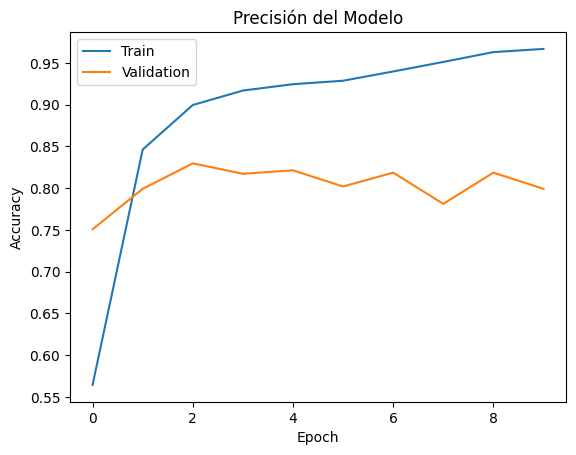

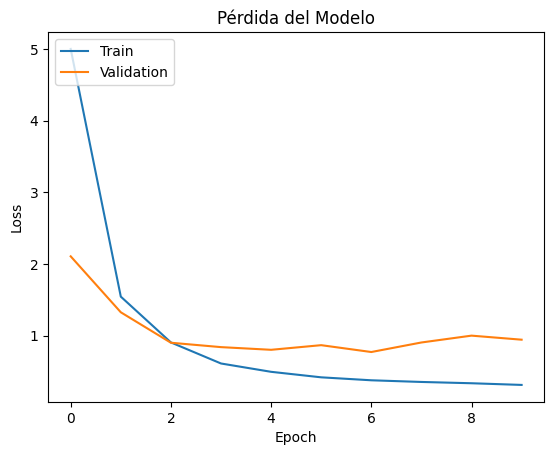

In [16]:
#print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Prediciones sobre el set de Test

In [17]:
# Levantamos el mejor modelo
model.load_weights('weights.h5')

# Predicciones de los datos en test
y_pred = model.predict(X_test)
print(y_pred)

# Devuelve un vector con la pertenencia a cada clase, probabilidad

29/29 [==============================] - 2s 50ms/step
[[0.01020428 0.04467838 0.9451173 ]
 [0.02270802 0.07060833 0.90668356]
 [0.41034028 0.34170434 0.24795538]
 ...
 [0.29292294 0.3869416  0.32013544]
 [0.9677883  0.0273588  0.0048529 ]
 [0.26261306 0.3955815  0.34180543]]


In [18]:
# Pequeña función para evaluar la respuesta y obtener la clase emergente
def predict_class(y_pred):
    y_class = []
    for i in y_pred:
        y_class.append(int(np.where(i == np.amax(i))[0]))

    return np.array(y_class)

In [19]:
y_pred_class = predict_class(y_pred)
# Ahora se puede comparar directamente y_pred con y_test

In [20]:
y_pred_class
# Ahora queda en evidencia que una comparación visual es... poco eficiente :/

array([2, 2, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0,
       0, 2, 2, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2,
       2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,

In [21]:
y_test

array([2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2,
       2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 1, 2, 1, 0, 2, 0, 0, 0, 1, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 2,
       0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2,
       2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 0,
       0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2,
       0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 2, 0, 1, 2,
       2, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2,
       0, 0, 0, 1, 2, 1, 1, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0,
       2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,

### Métricas resultantes del test

In [22]:
print(classification_report(y_test, y_pred_class, digits=5))

              precision    recall  f1-score   support

           0    0.85429   0.87885   0.86640       487
           1    0.16667   0.13725   0.15054        51
           2    0.86389   0.85205   0.85793       365

    accuracy                        0.82614       903
   macro avg    0.62828   0.62272   0.62496       903
weighted avg    0.81933   0.82614   0.82254       903



Axes(0.125,0.11;0.62x0.77)


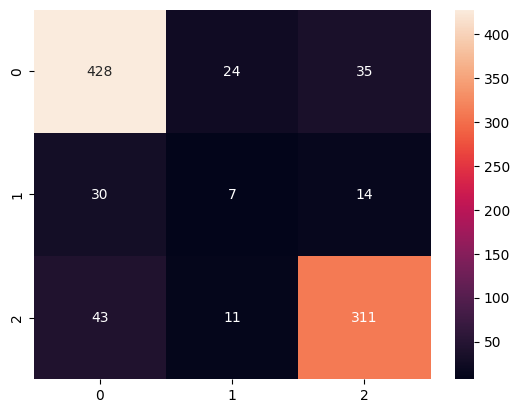

In [23]:
# Matriz de confusión, ahora con "más estilo"
print(sns.heatmap(confusion_matrix(y_test, y_pred_class), annot=True, fmt="d"))

# Hay problemas con la clase intermedia (neutro)
# Se debe a que los datos están desbalanceados, pasa mucho en la vida real
# Puede que se deba a que la distribución sea esa (muestreo correcto), o porque
# tenemos algún sesgo, etc.

# La cuestión es que... así como está, nuestra RNA reconoce únicamente comentarios
# POSITIVOS y NEGATIVOS, para los NEUTRALES... hay que usar otra ruta o estrategias

## Ejemplo de aplicación de la RNA

In [24]:
# Pequeña función para pruebas con el modelo
# Se realiza el mismo tratamiento original y se predice el sentimiento

model.load_weights('weights.h5')
def predict_sentimiento(stri):
    review = ''.join(char for char in stri if (char.isalnum() or char.isspace()))
    review = review.split()
    review = [word for word in review if not word in es_stopwords]
    review = ' '.join(review)
    onehot_repr = [one_hot(review, VOCABULARIO_LIM)]
    embed = pad_sequences(onehot_repr, padding='pre', maxlen=PAL_MAX)
    predict = model.predict(embed)
    return label_encoder.classes_[np.argmax(predict)]

In [25]:
# Pruebas predefinidas
test_manual = ["Pésima aplicación",
               "Excelente aplicación",
               "Podrían mejorar varios aspectos",
               "Que se yo, regular",
               "Hay muchos errores, pero me gusta",
               "Una porquería, literalmente",
               "Palabraquemeinventeahoraparaverqueonda",
               ]

for comentario in test_manual:
    print("Comentario: '{}' - Sentimiento: '{}'".format(comentario, predict_sentimiento(comentario)))

# ¿Tienen coherencia los resultados?

1/1 [==============================] - 0s 35ms/step
Comentario: 'Pésima aplicación' - Sentimiento: 'negativo'
1/1 [==============================] - 0s 32ms/step
Comentario: 'Excelente aplicación' - Sentimiento: 'positivo'
1/1 [==============================] - 0s 32ms/step
Comentario: 'Podrían mejorar varios aspectos' - Sentimiento: 'negativo'
1/1 [==============================] - 0s 35ms/step
Comentario: 'Que se yo, regular' - Sentimiento: 'negativo'
1/1 [==============================] - 0s 37ms/step
Comentario: 'Hay muchos errores, pero me gusta' - Sentimiento: 'positivo'
1/1 [==============================] - 0s 32ms/step
Comentario: 'Una porquería, literalmente' - Sentimiento: 'negativo'
1/1 [==============================] - 0s 41ms/step
Comentario: 'Palabraquemeinventeahoraparaverqueonda' - Sentimiento: 'negativo'


In [26]:
# Espacio para probar comentarios de forma continua
# Para finalizar... cancelar la ejecución del bloque
while True:
    comentario = input("Escriba un comentario propio: ")
    print("Su comentario es: '{}'".format(predict_sentimiento(comentario)))

Escriba un comentario propio: tiene futuro la app
1/1 [==============================] - 0s 37ms/step
Su comentario es: 'negativo'
Escriba un comentario propio: tiene futuro
1/1 [==============================] - 0s 67ms/step
Su comentario es: 'negativo'
Escriba un comentario propio: Anda esta garompa
1/1 [==============================] - 0s 49ms/step
Su comentario es: 'negativo'
Escriba un comentario propio: anda
1/1 [==============================] - 0s 37ms/step
Su comentario es: 'positivo'
Escriba un comentario propio: funciona la mal educada
1/1 [==============================] - 0s 33ms/step
Su comentario es: 'negativo'
Escriba un comentario propio: una cagada pero esta buena
1/1 [==============================] - 0s 37ms/step
Su comentario es: 'positivo'
Escriba un comentario propio: mercado libre
1/1 [==============================] - 0s 63ms/step
Su comentario es: 'positivo'
Escriba un comentario propio: afip
1/1 [==============================] - 0s 64ms/step
Su comentario e

KeyboardInterrupt: ignored